## Data Preprocessing

In this part, we cleaned the dataset, remove uncorrelated variables, filter out the data we want to focus on and roughly analyzed it.

In [1]:
#Importing packages we want
import pandas as pd
import numpy as np
import collections
import re
import heapq
from collections import defaultdict
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [79]:
#Reading twitter data which are labeled as Russian Trolls
df = pd.read_csv('twitter.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (1,11,16,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## All those helper functions we build for cleaning the processing our dataset:

#Functions which can help us extract more time information 
def get_mdy(string):
    return string.split()[0]
def get_hm(string):
    return string.split()[1]
def get_month(string):
    return int(string.split('/')[0])
def get_date(string):
    return int(string.split('/')[1])
def get_hour(string):
    return int(string.split(':')[0])

#Functions which can help us extract all hash tags of one tweet
def get_hash_tags(contents):
    word_list = []
    for sentence in contents:
        if isinstance(sentence, str):
            word_list += re.findall('#(\w+)', sentence)
    return word_list

#Functions to count each hashtag
def count_hashtags(hash_tags):
    tag_to_num = collections.defaultdict(int)
    for hashtag in hash_tags:
        tag_to_num[hashtag] += 1 
    return tag_to_num

def get_hash_tag(content):
    if isinstance(content, str):
        word_list = re.findall('#(\w+)' , content)
        return word_list
    return []

def count_num(hash_list):
    return len(hash_list)

#Functions which can help us extract information after symbol '@' can count the number of them
pattern2 = '@(\w+)'
def get_at_tags(pattern, contents):
    word_list = []
    for sentence in contents:
        if isinstance(sentence, str):
            word_list += re.findall(pattern, sentence)
    return word_list
def count_attags(at_tags):
    tag_to_num = collections.defaultdict(int)
    for hashtag in at_tags:
        tag_to_num[hashtag] += 1 
    return tag_to_num

#Functions which can help us get the 5 most frequently appearing tags
def find_top5_ht(tag_list):
    tag_to_num = defaultdict(int)
    for tag in tag_list:
        tag_to_num[tag] += 1
    heap = []
    for tag in tag_to_num:
        heapq.heappush(heap, (tag_to_num[tag], tag))
    while len(heap) > 5:
        heapq.heappop(heap)
    return heap

def get_tags(tag_list):
    tags = []
    for num, tag in tag_list:
        tags.append(tag)
    tags = list(reversed(tags))
    return tags

#Functions helping us transforming tweet content to suitable format
def no_hashtag(content):
    number = [0]*len(content)
    for i in range(len(content)):
        pattern = re.compile(r'#\w+')
        number[i] = len(pattern.findall(content[i]))
    return number

def no_at(content):
    number = [0]*len(content)
    for i in range(len(content)):
        pattern = re.compile(r'@\w+')
        number[i] = len(pattern.findall(content[i]))
    return number

#Functions for wordcloud analysis
def remove_url(content):
    for i in range(len(content)):
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', content[i], flags=re.MULTILINE)
        content[i] = text
    return content

def remove_hashtags(content):
    for i in range(len(content)):
        text = re.sub(r'#\w+', '', content[i], flags=re.MULTILINE)
        content[i] = text
    return content

def remove_at(content):
    for i in range(len(content)):
        text = re.sub(r'@\w+', '', content[i], flags=re.MULTILINE)
        content[i] = text
    return content

def remove_stop_words(content):
    for i in range(len(content)):
        pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
        content[i] = pattern.sub('', content[i].lower())
    return content

#Other functions
def remove_punctuations(content):
    for i in range(len(content)):
        pattern = re.compile(r'[^\w\s]')
        content[i] = pattern.sub('',content[i])
    return content

def sentiment_score(s:str):
    score = TextBlob(s).sentiment[0]
    return score

def contain_topic(topic:str,s:str):
    topic_pattern = re.compile(topic)
    matching = topic_pattern.search(s.lower())
    return (matching != None)

In [4]:
#Checking structure of the dataset
df.head()

,Unnamed: 0,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


From the table above we can find that there might be some columns that are not closely related with our final result, for example, columns like external_author_id, artical_url and tweet_id are used to distinguish one specific tweet. Under this circumstance, we can just drop them to get better prediction.

In [80]:
# Dropping some columns which may not be significant for our further analysis
df.drop(columns = ['Unnamed: 0', 'external_author_id', 'article_url', 'harvested_date', 'tweet_id'], axis = 1, inplace = True)

After dropping some of the unrelated variables, the next step we decided to do is working with the null value, which will influence our further analysis.

In [6]:
# Checking for null valus
df.isnull().sum()

author                    0
content                   1
region                 8818
language                  0
publish_date              0
following                 0
followers                 0
updates                   0
post_type           1648625
account_type              0
retweet                   0
account_category          0
new_june_2018             0
alt_external_id           0
tco1_step1           845971
tco2_step1          2235090
tco3_step1          2931207
dtype: int64

In [81]:
# Since there are too many null values in ['tco2_step1', 'tco3_step1'] columns, we can drop them 
df.drop(columns = ['tco2_step1', 'tco3_step1'], axis = 1, inplace = True)

In [8]:
# Getting the percentage of how many tweets come from the United States
print(df.region.unique())
print(len(df[df['region'] == 'United States']) / len(df))

['Unknown' nan 'United States' 'Italy' 'United Arab Emirates' 'Japan'
 'Israel' 'Azerbaijan' 'Egypt' 'United Kingdom' 'Russian Federation'
 'Turkey' 'Iraq' 'Germany' 'France' 'Ukraine' 'Serbia' 'Hong Kong'
 'Austria' 'Belarus' 'Malaysia' 'Spain' 'Samoa' 'India' 'Afghanistan'
 'Saudi Arabia' 'Iran, Islamic Republic of' 'Mexico' 'Canada' 'Greece'
 'Czech Republic' 'Finland' 'Latvia' 'Estonia' 'Sweden' 'Denmark'
 'Switzerland']
0.6946928712069451


In [9]:
# Getting the percentage of how many tweets are English
print(df.language.unique())
print(len(df[df['language'] == 'English']) / len(df))

['English' 'Russian' 'Serbian' 'Ukrainian' 'Tagalog (Filipino)' 'Albanian'
 'Italian' 'Romanian' 'Spanish' 'Catalan' 'German' 'Estonian' 'French'
 'Norwegian' 'Vietnamese' 'Dutch' 'Arabic' 'Uzbek' 'Bulgarian'
 'Macedonian' 'Farsi (Persian)' 'Turkish' 'LANGUAGE UNDEFINED' 'Czech'
 'Somali' 'Lithuanian' 'Croatian' 'Slovak' 'Icelandic' 'Slovenian'
 'Japanese' 'Indonesian' 'Pushto' 'Hungarian' 'Finnish' 'Latvian'
 'Portuguese' 'Danish' 'Swedish' 'Malay' 'Polish' 'Korean' 'Hebrew' 'Urdu'
 'Kurdish' 'Hindi' 'Greek' 'Simplified Chinese' 'Thai' 'Bengali'
 'Traditional Chinese' 'Gujarati' 'Kannada' 'Tamil' 'Telugu' 'Malayalam']
0.7185058619438485


Based on these two numbers - 69.46% and 71.85%, we know that most of the tweets are written in English and sent from the United States, so we can only using data that matches these two criteria.

In [82]:
#Filter out the data we want to focus on
df = df[df['language'] == 'English']
df = df[df['region'] == 'United States']

Based on our assumption, those Troll acounts will be more actively when politics events happened, to check for the correctness of this assumption, we hope we can extract more time information, helping us match different pattern with specific events. To do so, we build more features showing more time information about each tweet.


In [83]:
#Split data
df['pb_mdy_info'] = df.publish_date.apply(get_mdy)
df['pb_hm_info'] = df.publish_date.apply(get_hm)

In [84]:
#Tansfer original date data into standard forms we want
df['pb_month'] = df.pb_mdy_info.apply(get_month)
df['pb_date'] = df.pb_mdy_info.apply(get_date)
df['pb_hour'] = df.pb_hm_info.apply(get_hour)

In [85]:
#Dataset structure after basic cleaning
df.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tco1_step1,pb_mdy_info,pb_hm_info,pb_month,pb_date,pb_hour
424,1D_NICOLE_,#FoodPoisoning is not a joke! #Walmart #KochFa...,United States,English,11/26/2015 22:20,48,40,394,RETWEET,Koch,1,Fearmonger,0,2535564756,https://twitter.com/Ina_Malone/status/67000248...,11/26/2015,22:20,11,26,22
425,1D_NICOLE_,Thanks God that #turkey i ate few days ago was...,United States,English,11/26/2015 22:35,48,40,395,RETWEET,Koch,1,Fearmonger,0,2535564756,https://twitter.com/Willie_BigN/status/6700043...,11/26/2015,22:35,11,26,22
426,1D_NICOLE_,"I hurt easy, I just don't show it. You can hur...",United States,English,5/25/2015 12:38,59,51,354,NaN,Koch,0,Fearmonger,0,2535564756,NaN,5/25/2015,12:38,5,25,12
428,1D_NICOLE_,"who's got the worst make up ever, don't tell m...",United States,English,5/25/2015 12:38,59,51,352,NaN,Koch,0,Fearmonger,0,2535564756,NaN,5/25/2015,12:38,5,25,12
429,1D_NICOLE_,jade doesn`t love her! https://t.co/fEOsiKho7C,United States,English,5/25/2015 12:39,59,51,357,NaN,Koch,0,Fearmonger,0,2535564756,https://vine.co/v/OIPJQ21bwg9,5/25/2015,12:39,5,25,12


Hash tag is an important part we want to focus on because it represents the topic of each tweets, in order to split hash tags from tweets, we defined some helper functions using regular expresssion. Then, after geting hash tags, we grouped them and count to see what topics are people most care about.

In [14]:
# Getting hashtags from tweets(Using regex)

In [15]:
contents = df['content'].tolist()

In [16]:
#Applying fuction to dataset and get hashtags
hash_tags = get_hash_tags(contents)

In [17]:
# Checking for some of our results
hash_tags[:20]

['FoodPoisoning',
 'Walmart',
 'KochFarms',
 'turkey',
 'KochFarms',
 'JasonAldean',
 'hungry',
 'DumbGenieWishes',
 'DumbGenieWishes',
 'YoLandi',
 'DumbGenieWishes',
 'petition',
 'NoGunsForCriminals',
 'black',
 'NoGunsForCriminals',
 'Raiders',
 'Carr',
 'RaiderNation',
 'Raiders',
 'MikeAndMolly']

In [18]:
# Counting the number of different hashtags
tag_to_num = count_hashtags(hash_tags)
tag_to_num

defaultdict(int,
            {'FoodPoisoning': 772,
             'Walmart': 960,
             'KochFarms': 3748,
             'turkey': 885,
             'JasonAldean': 40,
             'hungry': 10,
             'DumbGenieWishes': 280,
             'YoLandi': 1,
             'petition': 93,
             'NoGunsForCriminals': 432,
             'black': 237,
             'Raiders': 21,
             'Carr': 2,
             'RaiderNation': 32,
             'MikeAndMolly': 3,
             'CaitlynJenner': 75,
             'ConversationWithAlanis': 13,
             'HOLYPOOPICANPUTT': 2,
             'WillSmith': 11,
             'DearSugarRadio': 2,
             'GOPDebate': 3864,
             'VegasGOPDebate': 2320,
             'Cruz': 165,
             'Bush': 66,
             'CNNDebate': 220,
             'Power100': 2,
             'WCW': 334,
             'wordsofwisdom': 5,
             'quoteoftheday': 37,
             'IslamKills': 3955,
             'tousensemble': 8,
          

In [19]:
#How many unique hashtags we got
len(tag_to_num)

85146

After extracting information related to hashtag, we started to think which variable might also be significant for our prediction, and the answer is information hided by the '@' symbol. So we use different tools trying to get those data.

In [20]:
at_list = get_at_tags(pattern2, contents)

In [21]:
at_to_num = count_attags(at_list)
at_to_num

defaultdict(int,
            {'DrGregoryWest': 8,
             'HalfOnionInABag': 3,
             'cmath_72': 1,
             'CBS': 125,
             'Grandfathered': 3,
             'peopleschoice': 6,
             'robdelaney': 16,
             'meed429': 3,
             'ClevelandGolf': 2,
             'wizkhalifa': 59,
             'iTunesPodcasts': 16,
             'thisamerlife': 2,
             'duncantrussell': 2,
             'CherylStrayed': 2,
             'SenTedCruz': 149,
             'JohnKasich': 163,
             'CarlyFiorina': 64,
             'maccosmetics': 5,
             'jnevandcourtney': 4,
             'DooM_Tasty': 1,
             'big_gun_in_utah': 2,
             'ShaunKing': 612,
             'Plantflowes': 3,
             'chrisrock': 22,
             'deray': 907,
             'realDonaldTrump': 12733,
             'FoxNews': 2839,
             'HillaryClinton': 4332,
             'gloed_up': 136,
             'genericpanic': 1,
             'bridgie_xo

In [22]:
#Seeing the remaining null values in dataset
df.isnull().sum()

author                    0
content                   1
region                    0
language                  0
publish_date              0
following                 0
followers                 0
updates                   0
post_type           1023675
account_type              0
retweet                   0
account_category          0
new_june_2018             0
alt_external_id           0
tco1_step1           722589
pb_mdy_info               0
pb_hm_info                0
pb_month                  0
pb_date                   0
pb_hour                   0
dtype: int64

In [23]:
#Post type of tweets
df.post_type.unique()

array(['RETWEET', nan, 'QUOTE_TWEET'], dtype=object)

## Descriptive Analysis

In this part we dived deeper in our dataset and did some basic descriptive analysis, from the plots we can clearly see Tweets trends and accounts with more followers. Also, we grouped tweets by day and find top 5 hashtags of each day to see whether there's any pattern. Used aggregate function to generate informations of each accounts including total posts, average following, average followers, usually posting time, what kinds of hashtags they have used and their account type.

In [24]:
# Some basic descriptive analysis

In [25]:
df['account_category'].value_counts().plot('bar')

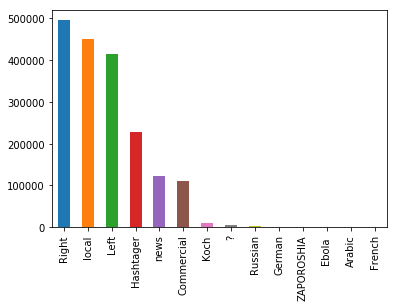

In [26]:
df['account_type'].value_counts().plot('bar')

In [27]:
#See the top tag of these tweets
sorted(tag_to_num.items(), key = lambda item: item[1], reverse=True)
#We can find that there're many tags related to politics

[('news', 126871),
 ('sports', 48042),
 ('politics', 39519),
 ('world', 27518),
 ('local', 24789),
 ('TopNews', 15135),
 ('health', 11479),
 ('BlackLivesMatter', 11418),
 ('tcot', 11260),
 ('business', 10832),
 ('MAGA', 10139),
 ('PJNET', 9337),
 ('tech', 8221),
 ('entertainment', 7511),
 ('Cleveland', 6668),
 ('crime', 6503),
 ('TopVideo', 6452),
 ('environment', 5777),
 ('NowPlaying', 5228),
 ('Trump', 4528),
 ('breaking', 4508),
 ('FAKENEWS', 4332),
 ('SanJose', 4150),
 ('2A', 4033),
 ('WakeUpAmerica', 4032),
 ('IslamKills', 3955),
 ('life', 3924),
 ('GOPDebate', 3864),
 ('KochFarms', 3748),
 ('DemnDebate', 3566),
 ('Miami', 3440),
 ('ToDoListBeforeChristmas', 3395),
 ('ccot', 3392),
 ('Chicago', 3289),
 ('TCOT', 3072),
 ('amb', 2895),
 ('DemDebate', 2837),
 ('ThingsYouCantIgnore', 2764),
 ('ISIS', 2730),
 ('Texas', 2621),
 ('TrumpTrain', 2586),
 ('p2', 2560),
 ('IGetDepressedWhen', 2493),
 ('IHatePokemonGoBecause', 2442),
 ('SanDiego', 2441),
 ('US', 2435),
 ('Foke', 2409),
 ('Brea

In [28]:
#How many unique accounts
df.author.nunique()

1264

In [29]:
#Maybe in later analysis we can filter those accounts without any followers bacuse they may not have much impact on citizens
df.groupby('author')['followers'].max().sort_values(ascending = False)

author
TEN_GOP            145244
KADIROVRUSSIA       92788
NOVOSTISPB          82213
JENN_ABRAMS         71022
PAMELA_MOORE13      70734
TODAYNYCITY         62088
ELEVEN_GOP          59100
CRYSTAL1JOHNSON     56725
WOKELUISA           55467
SOUTHLONESTAR       53782
COLDWAR20_RU        45088
USA_GUNSLINGER      43895
THEFOUNDINGSON      42000
BLACKNEWSOUTLET     40788
KANIJJACKSON        32372
WASHINGTONLINE      32191
PIGEONTODAY         30486
BLACKTOLIVE         29469
NEWORLEANSON        28785
MARGOSAVAZH         28054
WARFAREWW           26740
LUGANSKNOVOSTI      26358
KANSASDAILYNEWS     25871
DANAGEEZUS          24663
ANDYHASHTAGGER      23890
SANANTOTOPNEWS      22250
DALLASTOPNEWS       22205
TPARTYNEWS          22009
CHRIXMORGAN         21760
CHICAGODAILYNEW     21712
                    ...  
WHATSUPPPADAMS          0
DNT_SHOOT               0
CDAVISA20               0
CHAYKA_CHELSEY          0
VESTNIKPSKOV            0
CTHUNO                  0
KIRILLANDY              0
AMBBE

In [30]:
top_following = list(df.groupby('author')['followers'].max().sort_values(ascending = False)[:100].index)

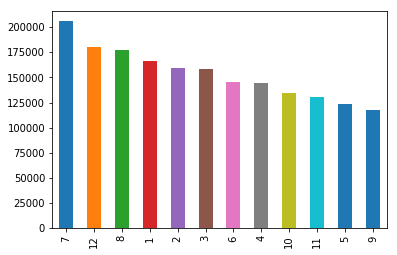

In [31]:
#Tweets trend in months
df.pb_month.value_counts().plot('bar')

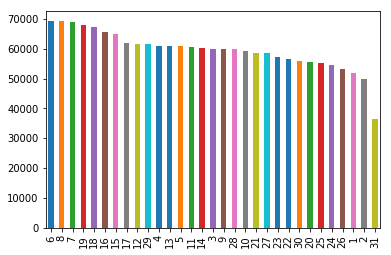

In [32]:
#Tweets trend in days
# These accounts tend to tweets during the middle of months
df.pb_date.value_counts().plot('bar')

In [33]:
df.post_type.value_counts()

RETWEET        792911
QUOTE_TWEET     27865
Name: post_type, dtype: int64

In [34]:
#About half of the handles follow more than 500 accounts
df.groupby('author')['following'].max().sort_values(ascending = False).loc[lambda x: x > 500].count()

535

In [86]:
df['hashtags'] = df.content.apply(get_hash_tag)

In [87]:
df['hashtag_num'] = df.hashtags.apply(count_num)

In [37]:
#Use aggregate function to count how many hashtags in each tweet
time_df = df.groupby('pb_mdy_info').agg({'hashtags': 'sum', 'hashtag_num': 'count'})

In [38]:
time_df['top5_tags'] = time_df.hashtags.apply(find_top5_ht)

In [39]:
time_df['top_5_tag'] = time_df.top5_tags.apply(get_tags)

In [40]:
time_df.head()

,hashtags,hashtag_num,top5_tags,top_5_tag
pb_mdy_info,,,,
1/1/2013,[],1,[],[]
1/1/2016,"[thankSAll, sports, sports, sports, sports, sp...",903,"[(32, local), (54, politics), (38, world), (10...","[news, sports, world, politics, local]"
1/1/2017,"[recipe, Can_I_Live, ad, recipe, NowPlaying, p...",2317,"[(17, HappyNewYear), (19, tcot), (24, 2A), (21...","[MAGA, NowPlaying, 2A, tcot, HappyNewYear]"
1/10/2015,"[ff, ff, MarkTwain, TheAdventuresofTomSawyer, ...",391,"[(6, entertainment), (10, politics), (20, loca...","[news, sports, local, politics, entertainment]"
1/10/2016,"[blacklivesmatter, blm, equality, equalrights,...",1687,"[(38, local), (65, politics), (40, world), (10...","[news, sports, world, politics, local]"


In [88]:
df.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,new_june_2018,alt_external_id,tco1_step1,pb_mdy_info,pb_hm_info,pb_month,pb_date,pb_hour,hashtags,hashtag_num
424,1D_NICOLE_,#FoodPoisoning is not a joke! #Walmart #KochFa...,United States,English,11/26/2015 22:20,48,40,394,RETWEET,Koch,...,0,2535564756,https://twitter.com/Ina_Malone/status/67000248...,11/26/2015,22:20,11,26,22,"[FoodPoisoning, Walmart, KochFarms]",3
425,1D_NICOLE_,Thanks God that #turkey i ate few days ago was...,United States,English,11/26/2015 22:35,48,40,395,RETWEET,Koch,...,0,2535564756,https://twitter.com/Willie_BigN/status/6700043...,11/26/2015,22:35,11,26,22,"[turkey, KochFarms]",2
426,1D_NICOLE_,"I hurt easy, I just don't show it. You can hur...",United States,English,5/25/2015 12:38,59,51,354,NaN,Koch,...,0,2535564756,NaN,5/25/2015,12:38,5,25,12,[],0
428,1D_NICOLE_,"who's got the worst make up ever, don't tell m...",United States,English,5/25/2015 12:38,59,51,352,NaN,Koch,...,0,2535564756,NaN,5/25/2015,12:38,5,25,12,[],0
429,1D_NICOLE_,jade doesn`t love her! https://t.co/fEOsiKho7C,United States,English,5/25/2015 12:39,59,51,357,NaN,Koch,...,0,2535564756,https://vine.co/v/OIPJQ21bwg9,5/25/2015,12:39,5,25,12,[],0


In [42]:
#Analysis below is user information part

In [89]:
df['post'] = 1
grouped = df.groupby('author')

In [44]:
df.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,alt_external_id,tco1_step1,pb_mdy_info,pb_hm_info,pb_month,pb_date,pb_hour,hashtags,hashtag_num,post
424,1D_NICOLE_,#FoodPoisoning is not a joke! #Walmart #KochFa...,United States,English,11/26/2015 22:20,48,40,394,RETWEET,Koch,...,2535564756,https://twitter.com/Ina_Malone/status/67000248...,11/26/2015,22:20,11,26,22,"[FoodPoisoning, Walmart, KochFarms]",3,1
425,1D_NICOLE_,Thanks God that #turkey i ate few days ago was...,United States,English,11/26/2015 22:35,48,40,395,RETWEET,Koch,...,2535564756,https://twitter.com/Willie_BigN/status/6700043...,11/26/2015,22:35,11,26,22,"[turkey, KochFarms]",2,1
426,1D_NICOLE_,"I hurt easy, I just don't show it. You can hur...",United States,English,5/25/2015 12:38,59,51,354,NaN,Koch,...,2535564756,NaN,5/25/2015,12:38,5,25,12,[],0,1
428,1D_NICOLE_,"who's got the worst make up ever, don't tell m...",United States,English,5/25/2015 12:38,59,51,352,NaN,Koch,...,2535564756,NaN,5/25/2015,12:38,5,25,12,[],0,1
429,1D_NICOLE_,jade doesn`t love her! https://t.co/fEOsiKho7C,United States,English,5/25/2015 12:39,59,51,357,NaN,Koch,...,2535564756,https://vine.co/v/OIPJQ21bwg9,5/25/2015,12:39,5,25,12,[],0,1


In [45]:
#Use aggregate function to generate information of each accounts
user_info = grouped.agg({'post': 'sum', 'following': 'mean', 'pb_hour': 'mean',  'followers': 'mean', 'hashtag_num': 'mean', 'hashtags':'sum', 'account_type': 'max'})
user_info

,post,following,pb_hour,followers,hashtag_num,hashtags,account_type
author,,,,,,,
1D_NICOLE_,41,58.463415,12.756098,51.414634,0.268293,"[FoodPoisoning, Walmart, KochFarms, turkey, Ko...",Koch
1ERIK_LEE,2,239.000000,9.000000,74.000000,2.000000,"[petition, NoGunsForCriminals, black, NoGunsFo...",Right
2NDHALFONION,3,22.000000,22.000000,1.000000,0.000000,[],Right
4EVER_SUSAN,62,75.661290,13.790323,57.822581,1.580645,"[Raiders, Carr, RaiderNation, Raiders, MikeAnd...",Right
4MYSQUAD,4767,2276.242291,13.077617,1158.421649,1.641703,"[blacklivesmatter, blm, equality, equalrights,...",Left
5EMEN5EMENICH,1,552.000000,16.000000,718.000000,2.000000,"[PutinPeacemaker, UNGA]",Russian
AAASSSSSHHH,71,27.633803,8.985915,40.225352,2.126761,"[Happy, Thanksgiving, Thanksgiving, thanksgivi...",Koch
AANTIRACIST,1239,904.519774,13.627119,747.964487,0.670702,"[targets, iceisis, opiceisis, DemDebate, MLKDa...",Left
AARONALLENALL,17,52.058824,2.588235,51.117647,2.352941,"[KochFarms, turkey, KochFarms, Kochfarms, DogT...",Koch


## Wordcloud Analysis

In [50]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate(' '.join(hash_tags))

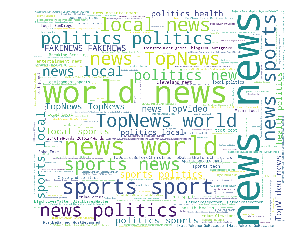

In [51]:
# wordcloud from hashtages
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('hash_tag_wordcloud.png')

In [52]:
content = list(df['content'])

In [72]:
content = remove_url(content)
content = remove_hashtags(content)
content = remove_at(content)
content_str = ' '.join(content)

In [73]:
from PIL import Image
stopwords = set(STOPWORDS)
more_words = ['now', 'said', 'say', 'amp', 'one']
for i in more_words:
    stopwords.add(i)

In [74]:
import numpy as np
from wordcloud import ImageColorGenerator

# read the mask / color image taken from
dt_coloring = np.array(Image.open("dt0.jpg"))

wc = WordCloud(background_color="white", max_words=2000, mask=dt_coloring,
               stopwords=stopwords, max_font_size=200, random_state=42).generate(content_str)

# create coloring from image
image_colors = ImageColorGenerator(dt_coloring)

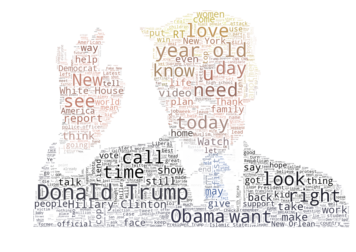

<Figure size 432x288 with 0 Axes>

In [75]:
# wordcloud from cleaned contents
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.figure()
wc.to_file('content_colored_no_noise.png')

## Building Machine Learning Models

After cleaned our dataset, did some feature engineering and made some descriptive analysis. Our team started to think what kind of process we should follow if we want to use our model for the upcoming election. Is putting each data to one complicated NLP model a good choice? We don't think so, since to do so, we should first transform all context to vectors and then call our model. This solution will cost a lot of money and time.


To better deal with this problem, we seperate our process of checking whether a tweet might be a problematic one to two steps:


First we build a model, which can help us quickly clarify whether this tweet includes political information. If it includes, we will send this data to our final model, which will save us a lot of time.


To build this first model, we use one new dataset, which includes tweet data and its corresponded label. Each label can be either 'Political' or 'Comment'. 
We train this model, to help us find what kind of tweet might need our further check.

In [46]:
# Reading this new dataset
political_df1 = pd.read_csv('general-tweets.txt',sep = '\t',names =['Political','comment'])
political_df2 = pd.read_csv('keyword-tweets.txt',sep = '\t', names = ['Political','comment'])
political_df = political_df1.append(political_df2)

In [47]:
# Transforming some of the columns so that we can better build our model
political_df['comment'] = remove_url(list(political_df['comment']))
political_df['comment'] = remove_hashtags(list(political_df['comment']))
political_df['comment'] = remove_at(list(political_df['comment']))
political_df['comment'] = remove_punctuations(list(political_df['comment']))
political_df['comment'] = political_df['comment'].apply(lambda s: s.lower())
political_df['Political'].value_counts()
political_df['Political'] = political_df['Political'].map({'NOT':0,'POLIT':1})

In [48]:
# Splitting dataset
X_train,X_test,y_train,y_test = train_test_split(political_df.comment,
                                                political_df.Political,test_size=0.2,stratify=political_df.Political,random_state =1)

In [49]:
# Defining the whole pipeline
def whole_pipeline(smoothing = 0.1,min_df = 1,max_df = 0.7,n_gram = (1,3),classfier =BernoulliNB()):
    param = {'vect__ngram_range': n_gram,
             'vect__stop_words':None,
             'vect__min_df':min_df,
             'vect__max_df':max_df,
             'vect__lowercase':True,             
          'clf__alpha': smoothing}
    NB_classifier = Pipeline([('vect',TfidfVectorizer()),('clf',classfier)])
    NB_classifier.set_params(**param)
    NB_classifier.fit(X_train,y_train)
    #vect, clf = NB_classifier.named_steps.vect, NB_classifier.named_steps.clf
    #feature_names = vect.get_feature_names()
    #most_inf = sorted(zip([clf.feature_log_prob_[1][i]-clf.feature_log_prob_[0][i] for i in range(len(clf.feature_log_prob_[0]))], feature_names))
    #df = pd.DataFrame({'word':[x[1] for x in most_inf], 'prob':[x[0] for x in most_inf]})
    #fig = px.histogram(df, x = 'prob', marginal="rug", hover_data =['word'])
    clf_report = classification_report(y_test,NB_classifier.predict(X_test))
    #out_sample_accuracy = NB_classifier.score(X_test,y_test)
    #in_sample_accuracy = NB_classifier.score(X_train,y_train)
    return NB_classifier
    #fig.show()

In [50]:
# Training this model
classifier = whole_pipeline()

In [51]:
# Checking for the performance of this model
classifier.score(X_test,y_test)
classifier.score(X_train,y_train)

0.993131439275679

In [52]:
# Using an simple example to check for our model
a_string = ['obama is a president','trump is a president']
classifier.predict(a_string)
feature_names = classifier.named_steps.vect.get_feature_names()
importance =classifier.named_steps.clf.feature_log_prob_[1] - classifier.named_steps.clf.feature_log_prob_[0]
importance_name = sorted(zip(importance,feature_names))
importance_name[-20:]

[(4.79559220766793, 'that is'),
 (4.79559220766793, 'wants to'),
 (4.899853217992339, 'politics'),
 (4.899853217992339, 'spending'),
 (4.994262902463413, 'administration'),
 (4.994262902463413, 'beck'),
 (4.994262902463413, 'rights'),
 (4.994262902463413, 'the republican'),
 (5.080523246747821, 'democrats'),
 (5.080523246747821, 'wants'),
 (5.233492591529248, 'americans'),
 (5.233492591529248, 'government is'),
 (5.233492591529248, 'iran'),
 (5.233492591529248, 'obama is'),
 (5.302012537966004, 'political'),
 (5.3661370661355425, 'ap'),
 (5.588037609210156, 'war'),
 (5.7271504116728735, 'the senate'),
 (5.88685152203078, 'healthcare'),
 (5.88685152203078, 'liberals')]

In [90]:
sum(df['content'].isna())

1

In [91]:
np.where(~df['content'].notnull())

(array([918986]),)

In [92]:
df['content'].iloc[918986] = ' '

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
# Using this model we build to work on our original dataset
result = classifier.predict(df['content'])
importance =classifier.named_steps.clf.feature_log_prob_[1] - classifier.named_steps.clf.feature_log_prob_[0]
sum(result)/len(result)

0.3364410331312678

## Machine Learning Models Continued

Now that we know how to separate political tweets from general tweets. We can send our political tweets to our second model.

The second model is to identify if a political tweet is a troll tweet. To do that, we need both normal tweets and troll tweets to label our data, in order to build a supervised learning model similar to the first model. However, we are unable to get access to a reasonable size of general tweets corresponding to our troll tweets. In the condition of having labeled data, we would be able to filter out the troll tweets and send to our final model for further analysis.

In the third model, we build a classification model to classify troll tweets into 5 different groups based on the content topics. We used LDA model to generate topics and K-means clustering for classification. This is the final step of our model building and would provide us a deeper understand of the component of troll tweets.

In [ ]:
# make a copyed dataframe for next model
df_copy = df.copy()
# remove the tweets whose account_category is commerical, and unknown,and NonEnglish
df_copy = df_copy[(df_copy['account_category'] !='NonEnglish') \
                  &(df_copy['account_category'] !='Commercial') \
                  &(df_copy['account_category'] !='Unknown')]

In [96]:
content = list(df_copy['content'])

In [97]:
# get number of hashtags and number of @ for each record
df_copy['no_hashtags'] = no_hashtag(content)
df_copy['no_at'] = no_at(content)

In [105]:
# format date
df_copy['pb_mdy_info'] = df_copy['pb_mdy_info'].astype('datetime64[ns]')

In [169]:
# get sentimental score
df_copy['score'] = df_copy['content'].apply(sentiment_score)

In [101]:
# add more features
df_copy['trump'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'trump',s = s))
df_copy['hillary'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'hillary',s= s))
df_copy['republican'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'republican',s=s))
df_copy['democrat'] = df_copy['content'].apply(lambda s: contain_topic(topic = 'democrat',s=s))

In [107]:
# clean content data
df_copy['content'] = remove_url(content)
df_copy['content'] = remove_stop_words(df_copy['content'].values)
df_copy['content'] = df_copy['content'].apply(lambda x: re.sub(r'#\w+', ' hashtag ', x))
df_copy['content'] = df_copy['content'].apply(lambda x: re.sub(r'@\w+', ' atpeople ', x))
df_copy['content'] = remove_punctuations(df_copy['content'].values)
df_copy['content'] = df_copy['content'].apply(lambda x: re.sub('[ ]+', ' ', x))

In [170]:
df_copy.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,hashtag_num,post,no_hashtags,no_at,trump,hillary,republican,democrat,topic,score
424,1D_NICOLE_,hashtag joke hashtag hashtag,United States,English,11/26/2015 22:20,48,40,394,RETWEET,Koch,...,3,1,3,0,False,False,False,False,1,0.000000
425,1D_NICOLE_,thanks god hashtag ate days ago good hashtag,United States,English,11/26/2015 22:35,48,40,395,RETWEET,Koch,...,2,1,2,0,False,False,False,False,3,0.450000
426,1D_NICOLE_,hurt easy show hurt someone even know,United States,English,5/25/2015 12:38,59,51,354,NaN,Koch,...,0,1,0,0,False,False,False,False,0,0.433333
428,1D_NICOLE_,got worst make ever tell mirror,United States,English,5/25/2015 12:38,59,51,352,NaN,Koch,...,0,1,0,0,False,False,False,False,0,-1.000000
429,1D_NICOLE_,jade love,United States,English,5/25/2015 12:39,59,51,357,NaN,Koch,...,0,1,0,0,False,False,False,False,0,0.500000


In [111]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
stop_words = stopwords.words('English')

In [112]:
# apply lda Model to content to generate topics
text_dictionary = Dictionary(df_copy['content'].apply(lambda x: x.split()))
text_dictionary.filter_extremes(no_below=5, #keep tokens whose doc frequency is at leaset a certain number
                                no_above=0.5) #keep tokens whose doc frequency is no more than a certain proportion
transformed_t = [text_dictionary.doc2bow(text) for text in df_copy.content.apply(lambda x: x.split())]

lda = LdaModel(transformed_t, 5,text_dictionary)

In [113]:
len(lda.get_document_topics(transformed_t))

1723984

In [114]:
lda.show_topics(formatted=False)

[(0,
  [('atpeople', 0.10271935),
   ('like', 0.014047027),
   ('people', 0.011154083),
   ('trump', 0.010714512),
   ('get', 0.008938099),
   ('make', 0.00859481),
   ('would', 0.00835435),
   ('know', 0.008009377),
   ('one', 0.007607409),
   ('want', 0.007165321)]),
 (1,
  [('hashtag', 0.30591238),
   ('new', 0.0040492397),
   ('fire', 0.003516894),
   ('president', 0.0030476109),
   ('sex', 0.0030009884),
   ('deal', 0.0029769067),
   ('north', 0.0028881577),
   ('dc', 0.0028764005),
   ('calls', 0.0027972036),
   ('city', 0.002672012)]),
 (2,
  [('black', 0.01494396),
   ('trump', 0.012398712),
   ('never', 0.010394026),
   ('white', 0.00999213),
   ('news', 0.008901794),
   ('go', 0.008651803),
   ('people', 0.008460465),
   ('women', 0.0077420278),
   ('game', 0.0075044944),
   ('media', 0.0070941946)]),
 (3,
  [('hashtag', 0.16982996),
   ('3', 0.0048277033),
   ('twitter', 0.0044760094),
   ('new', 0.0044705556),
   ('let', 0.0044612945),
   ('help', 0.0044316677),
   ('use', 

In [118]:
# get topics for each record
topics = lda.get_document_topics(transformed_t)
topics_docs = []

for idx,topic in enumerate(topics):
    topics_doc = [i[1] for i in topic]
    topics_docs.append(topics_doc.index(max(topics_doc)))
    
topic_arrays = np.array(topics_docs)
df_copy['topic'] = topic_arrays

df_copy.head()

,author,content,region,language,publish_date,following,followers,updates,post_type,account_type,...,hashtags,hashtag_num,post,no_hashtags,no_at,trump,hillary,republican,democrat,topic
424,1D_NICOLE_,hashtag joke hashtag hashtag,United States,English,11/26/2015 22:20,48,40,394,RETWEET,Koch,...,"[FoodPoisoning, Walmart, KochFarms]",3,1,3,0,False,False,False,False,1
425,1D_NICOLE_,thanks god hashtag ate days ago good hashtag,United States,English,11/26/2015 22:35,48,40,395,RETWEET,Koch,...,"[turkey, KochFarms]",2,1,2,0,False,False,False,False,3
426,1D_NICOLE_,hurt easy show hurt someone even know,United States,English,5/25/2015 12:38,59,51,354,NaN,Koch,...,[],0,1,0,0,False,False,False,False,0
428,1D_NICOLE_,got worst make ever tell mirror,United States,English,5/25/2015 12:38,59,51,352,NaN,Koch,...,[],0,1,0,0,False,False,False,False,0
429,1D_NICOLE_,jade love,United States,English,5/25/2015 12:39,59,51,357,NaN,Koch,...,[],0,1,0,0,False,False,False,False,0


In [171]:
grouped_df = df_copy.groupby(['author','account_category'], 
                             as_index = False).agg({'region':lambda x: x.nunique(),
                                                  'pb_mdy_info':['max','min',lambda x: (x.max() - x.min()).total_seconds()/(3600*24)],
                                                  'following':'mean',
                                                  'followers':'mean',
                                                  'retweet':'sum',
#                                                   'tweet_id':lambda x: x.nunique(),
                                                  'trump':sum,
                                                  'hillary':sum,
                                                  'republican':sum,
                                                  'democrat':sum,
                                                  'score':sum,
                                                  'no_hashtags':['mean','sum'],
                                                  'no_at':['mean','sum'],
                                                  'topic':dict(f1 = lambda x: (x==0).sum()/(x!=5).sum(),
                                                           f2 = lambda x: (x==1).sum()/(x!=5).sum(),
                                                           f3 = lambda x: (x==2).sum()/(x!=5).sum(),
                                                           f4 = lambda x: (x==3).sum()/(x!=5).sum(),
                                                           f5 = lambda x: (x==4).sum()/(x!=5).sum())
                                                   })
grouped_df.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


author account_category   region pb_mdy_info                      \
                                 <lambda>         max        min <lambda>   
0    1D_NICOLE_       Fearmonger        1  2015-11-26 2015-05-25    185.0   
1     1ERIK_LEE       RightTroll        1  2015-09-23 2015-09-23      0.0   
2  2NDHALFONION       RightTroll        1  2017-01-23 2017-01-23      0.0   
3   4EVER_SUSAN       RightTroll        1  2016-03-22 2015-12-09    104.0   
4      4MYSQUAD        LeftTroll        1  2016-12-09 2015-08-11    486.0   

     following    followers retweet trump    ...         score no_hashtags  \
          mean         mean     sum   sum    ...           sum        mean   
0    58.463415    51.414634       2   0.0    ...      3.732321    0.268293   
1   239.000000    74.000000       2   0.0    ...      0.200000    2.000000   
2    22.000000     1.000000       0   0.0    ...      0.958333    0.000000   
3    75.661290    57.822581      22   4.0    ...     -1.456227    1.580645   
4  2276.242291  1158.421649     688  85.0    ...     93.862943    1.565345   

            no_at           topic                                          
    sum      mean   sum        f1        f2        f3        f4        f5  
0    11  0.024390     1  0.414634  0.219512  0.121951  0.170732  0.073171  
1     4  0.000000     0  0.500000  0.000000  0.000000  0.500000  0.000000  
2     0  1.333333     4  1.000000  0.000000  0.000000  0.000000  0.000000  
3    98  0.258065    16  0.290323  0.258065  0.016129  0.387097  0.048387  
4  7462  0.582966  2779  0.426054  0.294105  0.071114  0.117894  0.090833  

[5 rows x 23 columns]

In [172]:
column_names = ['author','cls','region_change','max_date','min_date','active_days', 
                'following_mean','follower_mean','rt_count', #'tw_count',
                'trump','hillary','republican','democrat', 'score',
                'no_hashtags','no_hashtags_per_t','no_at','no_at_per_t',
                'topic_1','topic_2','topic_3','topic_4','topic_5']
grouped_df.columns = column_names

In [174]:
grouped_copy = grouped_df.copy()
# grouped_copy['avg_tweet'] = grouped_copy['tw_count']/grouped_copy['active_days']
grouped_copy['avg_rt'] = grouped_copy['rt_count']/grouped_copy['active_days']
grouped_copy.replace([np.inf,np.nan],0,inplace=True)

In [175]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['active_days','following_mean','follower_mean','rt_count', #'tw_count',
                    'trump','hillary','republican','democrat', 'score',
#                     'avg_tweet',
                    'avg_rt', 
                    'no_hashtags','no_hashtags_per_t','no_at','no_at_per_t', 
                    'topic_1','topic_2','topic_3','topic_4','topic_5']

for column in columns_to_scale:
    ss = StandardScaler()
    grouped_copy[[column]] = ss.fit_transform(grouped_copy[[column]])
    
columns_to_use = ['score',
                  'no_hashtags','no_hashtags_per_t','no_at','no_at_per_t', 
                  'topic_1','topic_2','topic_3','topic_4','topic_5']

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler

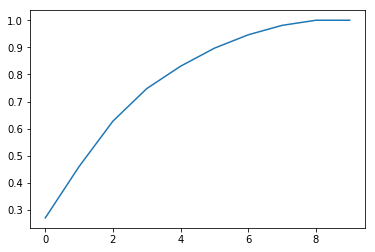

In [176]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
pca = PCA()
pca.fit(grouped_copy[columns_to_use])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [177]:
pca = PCA(n_components=5)
pca_6 = pca.fit_transform(grouped_copy[columns_to_use])

from sklearn.cluster import KMeans

n_clust = KMeans(n_clusters=5, random_state = 0)
n_clust.fit(grouped_copy[columns_to_use])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, \
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto', \
       random_state=0, tol=0.0001, verbose=0)

# our predicted clusters
cluster_result = n_clust.labels_

In [178]:
# get dictribution of predicted clusters
pd.DataFrame(cluster_result).iloc[:,0].value_counts()
# Out[341]:
# 3    535
# 0    272
# 1    258
# 2     86
# 4      2
# Name: 0, dtype: int64

1    481
0    259
2    129
3     82
4      2
Name: 0, dtype: int64

In [179]:
# get dictribution of original clusters
grouped_copy['label_us'] = n_clust.labels_ # add to data frame
orignal_label_count = df_copy.groupby(['author','account_category'],as_index=False).count()
orignal_label_count.account_category.value_counts()

RightTroll      461
LeftTroll       212
Fearmonger      122
HashtagGamer    110
NewsFeed         48
Name: account_category, dtype: int64

In [180]:
# asign cluster number with name based on distribution
label_dic = {'RightTroll':1,'LeftTroll':0,'Fearmonger':2,'HashtagGamer':3,'NewsFeed':4}
sum(grouped_copy['cls'].map(label_dic) == cluster_result)/len(cluster_result)
# 0.5524718126626192

0.3126967471143757

In [181]:
grouped_copy.head()
# cls is the original cluster, label_us is our predicted cluster

,author,cls,region_change,max_date,min_date,active_days,following_mean,follower_mean,rt_count,trump,...,no_hashtags_per_t,no_at,no_at_per_t,topic_1,topic_2,topic_3,topic_4,topic_5,avg_rt,label_us
0,1D_NICOLE_,Fearmonger,1,2015-11-26,2015-05-25,-0.426159,-0.383299,-0.300741,-0.365943,-0.352357,...,-0.322702,-0.827576,-0.259180,0.563288,-0.256049,0.243415,-0.197397,-0.530517,-0.118795,1
1,1ERIK_LEE,RightTroll,1,2015-09-23,2015-09-23,-1.127408,-0.328560,-0.296536,-0.365943,-0.352357,...,-0.324636,-0.922135,-0.259790,1.120303,-1.962374,-1.463199,3.223515,-1.280168,-0.119309,0
2,2NDHALFONION,RightTroll,1,2017-01-23,2017-01-23,-1.127408,-0.394355,-0.310127,-0.366806,-0.352357,...,-0.325742,4.247108,-0.257349,4.382819,-1.962374,-1.463199,-1.971203,-1.280168,-0.119309,1
3,4EVER_SUSAN,RightTroll,1,2016-03-22,2015-12-09,-0.733192,-0.378084,-0.299548,-0.357321,-0.342454,...,-0.298662,0.078363,-0.250025,-0.247849,0.043629,-1.237485,2.050514,-0.784431,-0.109256,0
4,4MYSQUAD,LeftTroll,1,2016-12-09,2015-08-11,0.714792,0.289138,-0.094640,-0.070197,-0.141918,...,1.736184,1.337985,1.436267,0.637804,0.323783,-0.468014,-0.746352,-0.349564,-0.052034,3
